In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ======================= 1. Install & Import ======================
# import torch
# print("Torch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("CUDA device count:", torch.cuda.device_count())


In [1]:
!pip install torch-ema

import os
import timm
import torch
import torch.nn as nn
from torchvision import transforms
# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import torch.multiprocessing as mp
# from dataset import Stanford40Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

# Class
from PIL import Image
from torch.utils.data import Dataset

# for report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from timm.data.mixup import Mixup
from torch_ema import ExponentialMovingAverage
import torchvision.models as models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

In [2]:
# ======================= 2. Custom Dataset ========================
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(split_file) as f:
            # danh sách tên ảnh (không .jpg)
            self.names = [l.strip().split(".")[0] for l in f if l.strip().split(".")[0]]
        # build list nhãn đầy đủ
        labels = sorted({self._label_from_name(n) for n in self.names})
        self.cls2idx = {c:i for i,c in enumerate(labels)}

    def _label_from_name(self, name):
        parts = name.split("_")
        return "_".join(parts[:-1])  # hoặc " ".join(parts[:-1])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(self.img_dir, name + ".jpg")
        img = Image.open(img_path).convert("RGB")
        label_str = self._label_from_name(name)
        label = self.cls2idx[label_str]
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
# ======================= 3. Hyperparams & Transforms ==============
NUM_CLASSES = 40
BATCH_SIZE = 8
LR = 2e-3 # Learning Rate
WD = 2e-2 # Weigth decay
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.4, 
        contrast=0.4, 
        saturation=0.4, 
        hue=0.1
    ),
    transforms.RandomRotation(degrees=10),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    transforms.RandomErasing(
        p=0.5, 
        scale=(0.02, 0.33), 
        ratio=(0.3, 3.3), 
        value='random'
    ),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

In [4]:
# ======================= 4. DataLoader ============================
DATA_ROOT = "/kaggle/input/stanford40"
train_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "train.txt"),
    transform=train_transform)
val_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "test.txt"),
    transform=val_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(train_loader.__len__)
print(val_loader.__len__)

<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7e9357224290>>
<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7e9438be0750>>


In [ ]:
# # =============== 5. Model ===============
# # model = timm.create_model("convit_base", pretrained=True)

# # # Freeze toàn bộ parameters trước
# # for param in model.parameters():
# #     param.requires_grad = False

# # # Thay classifier head
# # in_features = model.head.in_features
# # model.head = nn.Linear(in_features, NUM_CLASSES)

# # # Head mới có requires_grad=True theo mặc định
# # model = model.to(DEVICE)
# model = timm.create_model("convit_base", pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze 4 block Transformer (10, 11)
# for idx in [8, 11]:
#     for param in model.blocks[idx].parameters():
#         param.requires_grad = True

# in_features = model.head.in_features
# model.head = nn.Linear(in_features, NUM_CLASSES)
# model = model.to(DEVICE)

In [ ]:
# # ======================= 6. Optimizer, Scheduler, Loss ===========
# # optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9,
# #                                lr=LR, weight_decay= WD)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)


# # cosine + 5-epoch warm-up
# # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
# #               optimizer, T_max=15,
# #               eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)


# # criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)



In [ ]:
# # ======================= 7. Training Loop ========================
# train_losses = []
# val_losses   = []
# val_accs     = []

# NUM_EPOCHS = 50 # try 30 epoch when freeze head

# best_acc = 0.0
# for epoch in range(1, NUM_EPOCHS + 1):
#     # ======== Training ========
#     model.train()
#     running_train_loss = 0.0
#     num_train_samples = 0

#     for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]"):
#         imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         batch_size = imgs.size(0)
#         running_train_loss += loss.item() * batch_size
#         num_train_samples += batch_size

#     avg_train_loss = running_train_loss / num_train_samples
#     train_losses.append(avg_train_loss)
#     scheduler.step()

#     # ======== Validation ========
#     model.eval()
#     running_val_loss = 0.0
#     num_val_samples = 0
#     correct = 0

#     with torch.no_grad():
#         for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [ Val ]"):
#             imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
#             outputs = model(imgs)
#             loss = criterion(outputs, labels)

#             batch_size = imgs.size(0)
#             running_val_loss += loss.item() * batch_size
#             num_val_samples += batch_size

#             preds = outputs.argmax(dim=1)
#             correct += (preds == labels).sum().item()

#     avg_val_loss = running_val_loss / num_val_samples
#     val_losses.append(avg_val_loss)

#     acc = correct / num_val_samples
#     val_accs.append(acc)

#     print(
#         f"Epoch {epoch}/{NUM_EPOCHS} | "
#         f"Train Loss: {avg_train_loss:.4f} | "
#         f"Val Loss: {avg_val_loss:.4f} | "
#         f"Val Acc: {acc*100:.2f}%"
#     )

#     # ======== Save best ========
#     if acc > best_acc:
#         best_acc = acc
#         torch.save(model.state_dict(), "best_convit_stanford40.pth")

# print(f"Best Val Acc only head: {best_acc*100:.2f}%")

In [ ]:
model = timm.create_model("convit_base", pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# for idx in [8,9,10,11]: # Unfreeze nhiều block hơn
#     for param in model.blocks[idx].parameters():
#         param.requires_grad = True

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

mixup_fn = Mixup(
    mixup_alpha=0.4, cutmix_alpha=1.0, cutmix_minmax=None,
    prob=1.0, switch_prob=0.5, mode='batch',
    label_smoothing=0.1, num_classes=NUM_CLASSES)

ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

NUM_EPOCHS = 30
best_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        if mixup_fn is not None:
            imgs, labels = mixup_fn(imgs, labels)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ema.update()

        batch_size = imgs.size(0)
        running_train_loss += loss.item() * batch_size
        num_train_samples += batch_size

    scheduler.step()
    avg_train_loss = running_train_loss / num_train_samples

    # Validation với EMA weight
    ema.store()      # Lưu trạng thái weight hiện tại
    ema.copy_to()    # Dùng EMA weight cho model
    model.eval()
    running_val_loss, num_val_samples, correct = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            batch_size = imgs.size(0)
            running_val_loss += loss.item() * batch_size
            num_val_samples += batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    avg_val_loss = running_val_loss / num_val_samples
    acc = correct / num_val_samples
    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc*100:.2f}%")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_convit_ema.pth")
    ema.restore()    # Khôi phục lại weight ban đầu của model

print(f"Best Val Acc EMA: {best_acc*100:.2f}%")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
# ======== 9. Confusion Matrix and Classification report ========
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_ema.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded checkpoint.")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

In [ ]:
# ======================= 8. Loss and Accuracy ========================
epochs = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs)*100, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
# ======== 9. Confusion Matrix and Classification report ========
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_ema.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded checkpoint.")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

classes = [c for c, idx in sorted(train_ds.cls2idx.items(), key=lambda x: x[1])]

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 2) Classification report
# Cần list tên các class (40 labels) theo đúng thứ tự cls2idx
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print("=== Classification Report ===")
print(report)

In [ ]:
# === 9.1. TOP-5 maximum value in confusion matrix ===

# cm : numpy array (40, 40)
# create list tuple (count, true_idx, pred_idx)
flat_cm = [
    (int(cm[i, j]), i, j)
    for i in range(cm.shape[0])
    for j in range(cm.shape[1]) if (i != j)
]

# sort decs
flat_cm.sort(key=lambda x: x[0], reverse=True)

print("=== Top 20 values in Confusion Matrix ===")
for count, i, j in flat_cm[:20]:
    print(f"Count={count:4d} | True = '{classes[i]:<20}' | Pred = '{classes[j]:<20}'")
# Eg: Count= 123 | True = 'walking            ' | Pred = 'walking            '

In [ ]:
# === 9.2. F1-score for all class and print top10 highest / lowest ===

# precision, recall, f1_scores, support
precision, recall, f1_scores, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(classes)),
    zero_division=0  
)

# list tuple (f1, class_idx)
f1_with_idx = [(f1_scores[i], i) for i in range(len(classes))]

# Top-10 F1 highest
f1_with_idx.sort(key=lambda x: x[0], reverse=True)
print("\n=== Top 10 highest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")


In [ ]:
# Top-10 F1 lowest
f1_with_idx.sort(key=lambda x: x[0]) 
print("\n=== Top 10 lowest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")

In [ ]:
all_with_idx = [(precision[i], recall[i], f1_scores[i], support[i], i) for i in range(len(classes))]
all_with_idx.sort(key=lambda x: x[2]) 
for pre, rec, f1, sup, idx in all_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | precision = {pre:.4f} | recall = {rec:.4f} | F1 = {f1:.4f} | support = {sup}")

In [ ]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="final eval:"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

In [ ]:
# Cai thien bang class_weights_tensor, dat trong so cho tung class dua tren f1

In [5]:
f1_scores = [0.7885714285714285, 0.9411764705882353, 0.8374384236453202, 0.9478260869565216, 0.979381443298969, 0.8387096774193548, 0.9365853658536586, 0.7875647668393781, 0.7737704918032786, 0.9840425531914894, 0.9534883720930233, 0.9429657794676807, 0.9504950495049505, 0.8792270531400966, 0.9606299212598425, 0.9109947643979058, 0.9617486338797815, 0.8629441624365481, 0.7601246105919004, 0.9815303430079156, 0.9875776397515528, 0.7169811320754718, 0.9283018867924527, 0.7769784172661871, 0.9717223650385605, 0.9795918367346939, 0.9659090909090909, 0.8263888888888888, 0.9646017699115044, 0.7730496453900709, 0.7301587301587301, 0.7135678391959798, 0.8620689655172413, 0.9182879377431907, 0.9518716577540106, 0.7473684210526317, 0.959349593495935, 0.7377777777777778, 0.9239766081871345, 0.802721088435374]

In [ ]:
report = classification_report(all_labels, all_preds, target_names=classes, digits=4, output_dict=True, zero_division=0)
f1_scores = [report[c]['f1-score'] for c in classes]

In [6]:
print(f1_scores)

[0.7885714285714285, 0.9411764705882353, 0.8374384236453202, 0.9478260869565216, 0.979381443298969, 0.8387096774193548, 0.9365853658536586, 0.7875647668393781, 0.7737704918032786, 0.9840425531914894, 0.9534883720930233, 0.9429657794676807, 0.9504950495049505, 0.8792270531400966, 0.9606299212598425, 0.9109947643979058, 0.9617486338797815, 0.8629441624365481, 0.7601246105919004, 0.9815303430079156, 0.9875776397515528, 0.7169811320754718, 0.9283018867924527, 0.7769784172661871, 0.9717223650385605, 0.9795918367346939, 0.9659090909090909, 0.8263888888888888, 0.9646017699115044, 0.7730496453900709, 0.7301587301587301, 0.7135678391959798, 0.8620689655172413, 0.9182879377431907, 0.9518716577540106, 0.7473684210526317, 0.959349593495935, 0.7377777777777778, 0.9239766081871345, 0.802721088435374]


In [7]:
epsilon = 1e-4  # tránh chia 0
class_weights = 1.0 / (np.array(f1_scores) + epsilon)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # chuẩn hóa
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

In [9]:
train_losses = []
val_losses   = []
val_accs     = []

model = timm.create_model("convit_base", pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for idx in [8,9,10,11]: # Unfreeze nhiều block hơn
    for param in model.blocks[idx].parameters():
        param.requires_grad = True

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

mixup_fn = Mixup(
    mixup_alpha=0.4, cutmix_alpha=1.0, cutmix_minmax=None,
    prob=1.0, switch_prob=0.5, mode='batch',
    label_smoothing=0.1, num_classes=NUM_CLASSES)

ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

NUM_EPOCHS = 20
best_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        if mixup_fn is not None:
            imgs, labels = mixup_fn(imgs, labels)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ema.update()

        batch_size = imgs.size(0)
        running_train_loss += loss.item() * batch_size
        num_train_samples += batch_size

    scheduler.step()
    avg_train_loss = running_train_loss / num_train_samples
    train_losses.append(avg_train_loss)

    # Validation với EMA weight
    ema.store()      # Lưu trạng thái weight hiện tại
    ema.copy_to()    # Dùng EMA weight cho model
    model.eval()
    running_val_loss, num_val_samples, correct = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            batch_size = imgs.size(0)
            running_val_loss += loss.item() * batch_size
            num_val_samples += batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    avg_val_loss = running_val_loss / num_val_samples
    val_losses.append(avg_val_loss)
    acc = correct / num_val_samples

    val_accs.append(acc)
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc*100:.2f}%")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_convit_class_weights_tensor.pth")
    ema.restore()    # Khôi phục lại weight ban đầu của model

print(f"Best Val Acc EMA: {best_acc*100:.2f}%")

Epoch 1/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.45it/s]


Epoch 1/20 | Train Loss: 3.0503 | Val Loss: 1.7095 | Val Acc: 78.51%


Epoch 2/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.54it/s]


Epoch 2/20 | Train Loss: 2.4253 | Val Loss: 1.3434 | Val Acc: 83.73%


Epoch 3/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.54it/s]


Epoch 3/20 | Train Loss: 2.3128 | Val Loss: 1.2419 | Val Acc: 85.63%


Epoch 4/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.45it/s]


Epoch 4/20 | Train Loss: 2.1992 | Val Loss: 1.2041 | Val Acc: 86.41%


Epoch 5/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.48it/s]


Epoch 5/20 | Train Loss: 2.2135 | Val Loss: 1.1909 | Val Acc: 86.57%


Epoch 6/20 [ Val ]: 100%|██████████| 692/692 [00:48<00:00, 14.41it/s]


Epoch 6/20 | Train Loss: 2.2089 | Val Loss: 1.1675 | Val Acc: 86.66%


Epoch 7/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.54it/s]


Epoch 7/20 | Train Loss: 2.1403 | Val Loss: 1.1356 | Val Acc: 87.35%


Epoch 8/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.56it/s]


Epoch 8/20 | Train Loss: 2.1025 | Val Loss: 1.1088 | Val Acc: 87.94%


Epoch 9/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.58it/s]


Epoch 9/20 | Train Loss: 2.0313 | Val Loss: 1.0934 | Val Acc: 88.61%


Epoch 10/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.55it/s]


Epoch 10/20 | Train Loss: 2.0390 | Val Loss: 1.0834 | Val Acc: 88.85%


Epoch 11/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.58it/s]


Epoch 11/20 | Train Loss: 2.0254 | Val Loss: 1.0809 | Val Acc: 88.97%


Epoch 12/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.50it/s]


Epoch 12/20 | Train Loss: 2.0297 | Val Loss: 1.0796 | Val Acc: 88.88%


Epoch 13/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.52it/s]


Epoch 13/20 | Train Loss: 1.9578 | Val Loss: 1.0774 | Val Acc: 89.19%


Epoch 14/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.58it/s]


Epoch 14/20 | Train Loss: 1.9563 | Val Loss: 1.0778 | Val Acc: 89.03%


Epoch 15/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.58it/s]


Epoch 15/20 | Train Loss: 1.9811 | Val Loss: 1.0784 | Val Acc: 89.14%


Epoch 16/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.58it/s]


Epoch 16/20 | Train Loss: 1.9966 | Val Loss: 1.0731 | Val Acc: 89.30%


Epoch 17/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.52it/s]


Epoch 17/20 | Train Loss: 2.0008 | Val Loss: 1.0711 | Val Acc: 89.32%


Epoch 18/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.48it/s]


Epoch 18/20 | Train Loss: 1.9954 | Val Loss: 1.0697 | Val Acc: 88.97%


Epoch 19/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.47it/s]


Epoch 19/20 | Train Loss: 1.9683 | Val Loss: 1.0652 | Val Acc: 89.10%


Epoch 20/20 [ Val ]: 100%|██████████| 692/692 [00:47<00:00, 14.56it/s]

Epoch 20/20 | Train Loss: 1.9281 | Val Loss: 1.0647 | Val Acc: 88.99%
Best Val Acc EMA: 89.32%


In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
# ======== 9. Confusion Matrix and Classification report ========
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_class_weights_tensor.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded checkpoint.")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="calculate mAP:"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

Loaded checkpoint.


calculate mAP:: 100%|██████████| 692/692 [00:46<00:00, 14.79it/s]

=> mAP = 93.42%


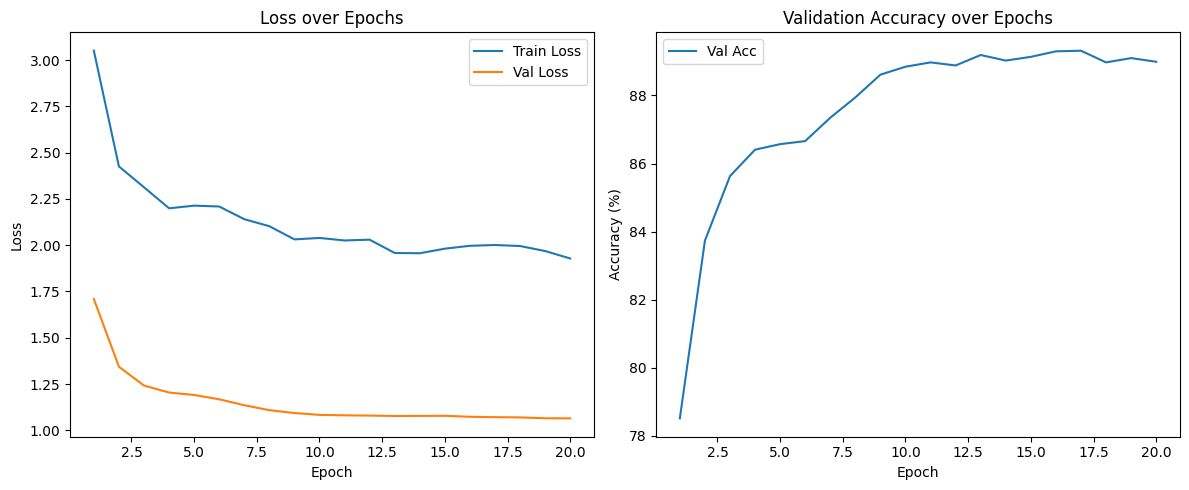

In [11]:
# ======================= 8. Loss and Accuracy ========================
epochs = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs)*100, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

Loaded checkpoint.


Final Eval [Val]: 100%|██████████| 692/692 [00:46<00:00, 14.78it/s]


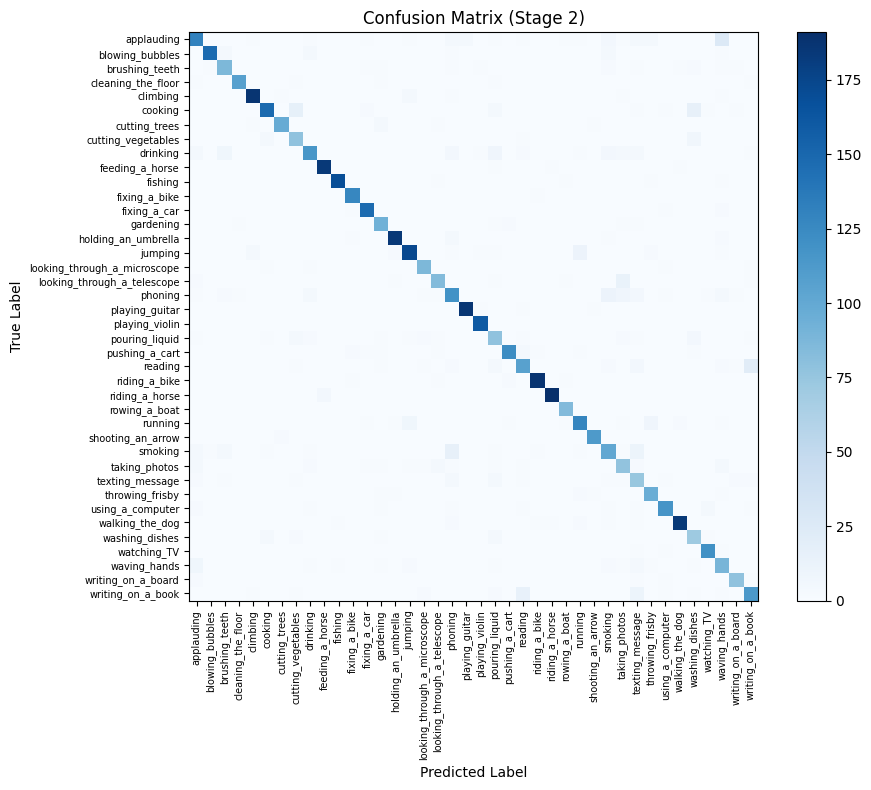

=== Classification Report ===
                              precision    recall  f1-score   support

                  applauding     0.8176    0.7065    0.7580       184
             blowing_bubbles     0.9866    0.9245    0.9545       159
              brushing_teeth     0.8365    0.8700    0.8529       100
          cleaning_the_floor     0.9817    0.9554    0.9683       112
                    climbing     0.9689    0.9590    0.9639       195
                     cooking     0.9367    0.7872    0.8555       188
               cutting_trees     0.9700    0.9417    0.9557       103
          cutting_vegetables     0.7573    0.8764    0.8125        89
                    drinking     0.8779    0.7372    0.8014       156
             feeding_a_horse     0.9735    0.9840    0.9787       187
                     fishing     0.9883    0.9769    0.9826       173
               fixing_a_bike     0.9621    0.9922    0.9769       128
                fixing_a_car     0.9545    0.9735    0.9639

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
# ======== 9. Confusion Matrix and Classification report ========
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_class_weights_tensor.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded checkpoint.")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

classes = [c for c, idx in sorted(train_ds.cls2idx.items(), key=lambda x: x[1])]

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 2) Classification report
# Cần list tên các class (40 labels) theo đúng thứ tự cls2idx
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print("=== Classification Report ===")
print(report)

In [13]:
# === 9.1. TOP-5 maximum value in confusion matrix ===

# cm : numpy array (40, 40)
# create list tuple (count, true_idx, pred_idx)
flat_cm = [
    (int(cm[i, j]), i, j)
    for i in range(cm.shape[0])
    for j in range(cm.shape[1]) if (i != j)
]

# sort decs
flat_cm.sort(key=lambda x: x[0], reverse=True)

print("=== Top 20 values in Confusion Matrix ===")
for count, i, j in flat_cm[:20]:
    print(f"Count={count:4d} | True = '{classes[i]:<20}' | Pred = '{classes[j]:<20}'")
# Eg: Count= 123 | True = 'walking            ' | Pred = 'walking            '

=== Top 20 values in Confusion Matrix ===
Count=  26 | True = 'applauding          ' | Pred = 'waving_hands        '
Count=  21 | True = 'reading             ' | Pred = 'writing_on_a_book   '
Count=  16 | True = 'cooking             ' | Pred = 'cutting_vegetables  '
Count=  15 | True = 'cooking             ' | Pred = 'washing_dishes      '
Count=  15 | True = 'smoking             ' | Pred = 'phoning             '
Count=  14 | True = 'writing_on_a_book   ' | Pred = 'reading             '
Count=  13 | True = 'looking_through_a_telescope' | Pred = 'taking_photos       '
Count=  11 | True = 'jumping             ' | Pred = 'running             '
Count=  11 | True = 'phoning             ' | Pred = 'smoking             '
Count=  10 | True = 'smoking             ' | Pred = 'texting_message     '
Count=  10 | True = 'writing_on_a_book   ' | Pred = 'texting_message     '
Count=   8 | True = 'drinking            ' | Pred = 'pouring_liquid      '
Count=   8 | True = 'phoning             ' | Pred =

In [14]:
# === 9.2. F1-score for all class and print top10 highest / lowest ===

# precision, recall, f1_scores, support
precision, recall, f1_scores, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(classes)),
    zero_division=0  
)

# list tuple (f1, class_idx)
f1_with_idx = [(f1_scores[i], i) for i in range(len(classes))]

# Top-10 F1 highest
f1_with_idx.sort(key=lambda x: x[0], reverse=True)
print("\n=== Top 10 highest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")


=== Top 10 highest F1-scores ===
Class = 'playing_violin      ' | F1 = 0.9877
Class = 'playing_guitar      ' | F1 = 0.9841
Class = 'fishing             ' | F1 = 0.9826
Class = 'riding_a_horse      ' | F1 = 0.9820
Class = 'feeding_a_horse     ' | F1 = 0.9787
Class = 'shooting_an_arrow   ' | F1 = 0.9782
Class = 'fixing_a_bike       ' | F1 = 0.9769
Class = 'riding_a_bike       ' | F1 = 0.9766
Class = 'rowing_a_boat       ' | F1 = 0.9714
Class = 'holding_an_umbrella ' | F1 = 0.9686


In [15]:
# Top-10 F1 lowest
f1_with_idx.sort(key=lambda x: x[0]) 
print("\n=== Top 10 lowest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")


=== Top 10 lowest F1-scores ===
Class = 'texting_message     ' | F1 = 0.6820
Class = 'waving_hands        ' | F1 = 0.7236
Class = 'smoking             ' | F1 = 0.7292
Class = 'taking_photos       ' | F1 = 0.7404
Class = 'pouring_liquid      ' | F1 = 0.7429
Class = 'phoning             ' | F1 = 0.7461
Class = 'applauding          ' | F1 = 0.7580
Class = 'reading             ' | F1 = 0.7626
Class = 'washing_dishes      ' | F1 = 0.7717
Class = 'writing_on_a_book   ' | F1 = 0.7820


In [16]:
all_with_idx = [(precision[i], recall[i], f1_scores[i], support[i], i) for i in range(len(classes))]
all_with_idx.sort(key=lambda x: x[2]) 
for pre, rec, f1, sup, idx in all_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | precision = {pre:.4f} | recall = {rec:.4f} | F1 = {f1:.4f} | support = {sup}")

Class = 'texting_message     ' | precision = 0.5968 | recall = 0.7957 | F1 = 0.6820 | support = 93
Class = 'waving_hands        ' | precision = 0.6544 | recall = 0.8091 | F1 = 0.7236 | support = 110
Class = 'smoking             ' | precision = 0.7426 | recall = 0.7163 | F1 = 0.7292 | support = 141
Class = 'taking_photos       ' | precision = 0.6937 | recall = 0.7938 | F1 = 0.7404 | support = 97
Class = 'pouring_liquid      ' | precision = 0.7091 | recall = 0.7800 | F1 = 0.7429 | support = 100
Class = 'phoning             ' | precision = 0.7438 | recall = 0.7484 | F1 = 0.7461 | support = 159
Class = 'applauding          ' | precision = 0.8176 | recall = 0.7065 | F1 = 0.7580 | support = 184
Class = 'reading             ' | precision = 0.7970 | recall = 0.7310 | F1 = 0.7626 | support = 145
Class = 'washing_dishes      ' | precision = 0.6961 | recall = 0.8659 | F1 = 0.7717 | support = 82
Class = 'writing_on_a_book   ' | precision = 0.7902 | recall = 0.7740 | F1 = 0.7820 | support = 146
